Описание данных
test.csv

ticket_id
agency_name
inspector_name
violator_name
violation_street_number
violation_street_name
violation_zip_code
mailing_address_str_number
mailing_address_str_name
city
state
zip_code
non_us_str_code
country
ticket_issued_date
hearing_date
violation_code
violation_description
disposition
fine_amount
admin_fee
state_fee
late_fee
discount_amount
clean_up_cost
judgment_amount
grafitti_status


In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from tabulate import tabulate

In [8]:
addresses_df = pd.read_csv('readonly/addresses.csv', encoding="cp1251", low_memory=False)
coords_df = pd.read_csv('readonly/latlons.csv', encoding="cp1251", low_memory=False)
df = pd.read_csv('readonly/train.csv', encoding="cp1251", low_memory=False)
df = df[df["compliance"].notna()]
useless_cols = ['admin_fee', 'state_fee', 'late_fee', 'grafitti_status', 'payment_amount','balance_due', 'payment_date', 
                'payment_status', 'collection_status']
for col in useless_cols:
    del df[col]
left = pd.merge(addresses_df, coords_df, how='left', left_on='address', right_on='address')
df = pd.merge(df, left, how='left', left_on='ticket_id', right_on='ticket_id') 
df.head(4)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,disposition,fine_amount,discount_amount,clean_up_cost,judgment_amount,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,Responsible by Default,250.0,0.0,0.0,305.0,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,Responsible by Determination,750.0,0.0,0.0,855.0,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,...,Responsible by Default,250.0,0.0,0.0,305.0,non-compliant by no payment,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233
3,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,...,Responsible by Default,750.0,0.0,0.0,855.0,non-compliant by no payment,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493


In [10]:
# df['agency_name'].unique()
agency_simplified_names = {'Buildings, Safety Engineering & Env Department': 'dep_buildings',
                           'Health Department': 'dep_health', 
                           'Department of Public Works': 'dep_pub_works',
                           'Detroit Police Department': 'dep_police', 
                           'Neighborhood City Halls': 'dep_halls'}
df['agency_name'] = df['agency_name'].apply(lambda x: agency_simplified_names.get(x))
df['agency_name'].unique()

array(['dep_buildings', 'dep_health', 'dep_pub_works', 'dep_police',
       'dep_halls'], dtype=object)

In [12]:
df = df.rename(columns={'compliance': 'target'})
df.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'discount_amount', 'clean_up_cost', 'judgment_amount',
       'compliance_detail', 'target', 'address', 'lat', 'lon'],
      dtype='object')

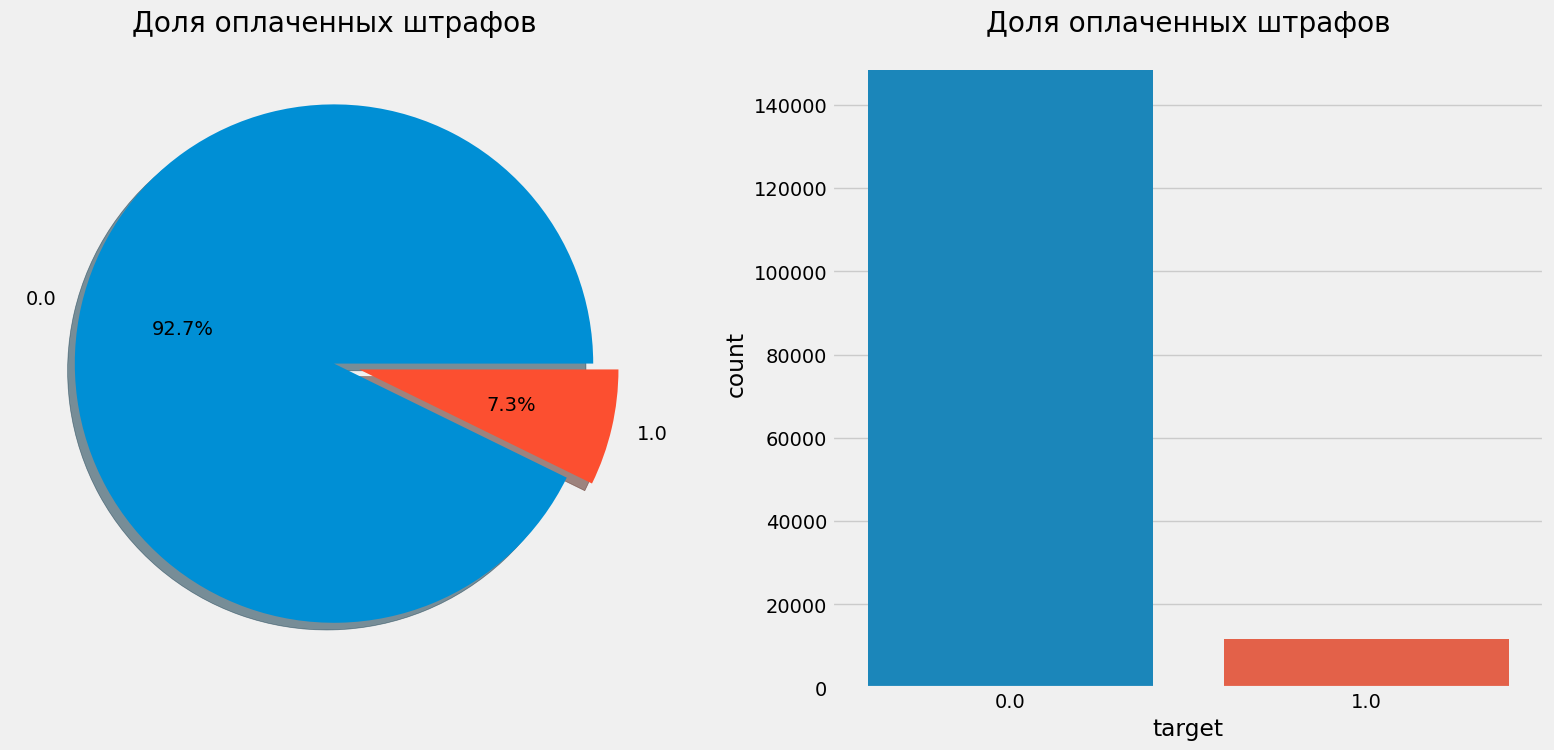

In [13]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)

ax[0].set_title('Доля оплаченных штрафов')
ax[0].set_ylabel('')
sns.countplot(x=df['target'],ax=ax[1])
ax[1].set_title('Доля оплаченных штрафов')
plt.show()

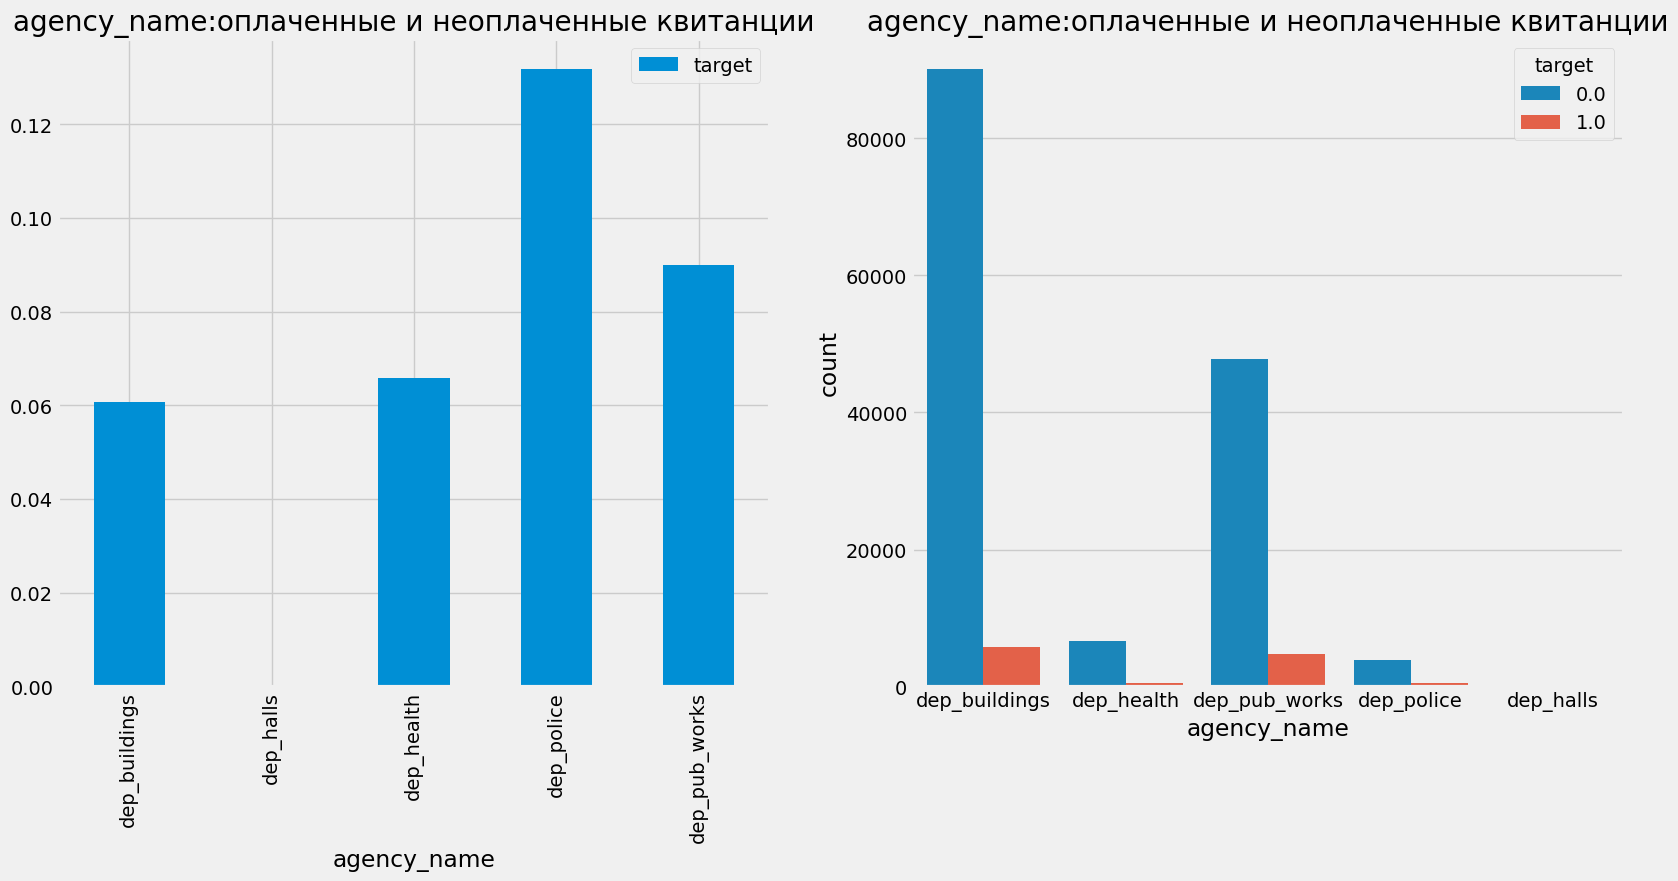

In [15]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df[['agency_name','target']].groupby(['agency_name']).mean().plot.bar(ax=ax[0])
ax[0].set_title('agency_name:оплаченные и неоплаченные квитанции')
sns.countplot(hue=df['target'], x=df['agency_name'],ax=ax[1])
ax[1].set_title('agency_name:оплаченные и неоплаченные квитанции')
plt.show()

In [26]:
# Рассмотрим типы судебных решений 
# df['disposition'].unique()
# 0 - 'Responsible by Default - в случаях когда ответчик не соизволил пожаловать в суд
# 2 - Responsible by Admission - это когда нарушитель признался, что говорит о том что он не совсем пропал для общества
# 1 - Determination - это когда нарушитель злостно отпирался, но его вину доказали
# 3 - Responsible (Fine Waived) - это когда штраф отменили (например, поняли что ничего не получат или стало жалко,
# что конечно маловероятно, или, допустим, он раскаялся и сказал что коноплю во дворе сам скосит и выкинет)
# Ergo, категории можно пронумеровать по степени качества нарушителя. Интересно, скидка коррелирует с категорией 2? 

disposition_simplified_names = {'Responsible by Default': 'disp_default',
                                'Responsible by Determination': 'disp_determin',
                                'Responsible by Admission': 'disp_admiss', 
                                'Responsible (Fine Waived) by Deter': 'disp_fine_waived'}
df['disposition'] = df['disposition'].apply(lambda x: disposition_simplified_names.get(x))
df['disposition'].unique()

array(['disp_default', 'disp_determin', 'disp_admiss', 'disp_fine_waived'],
      dtype=object)

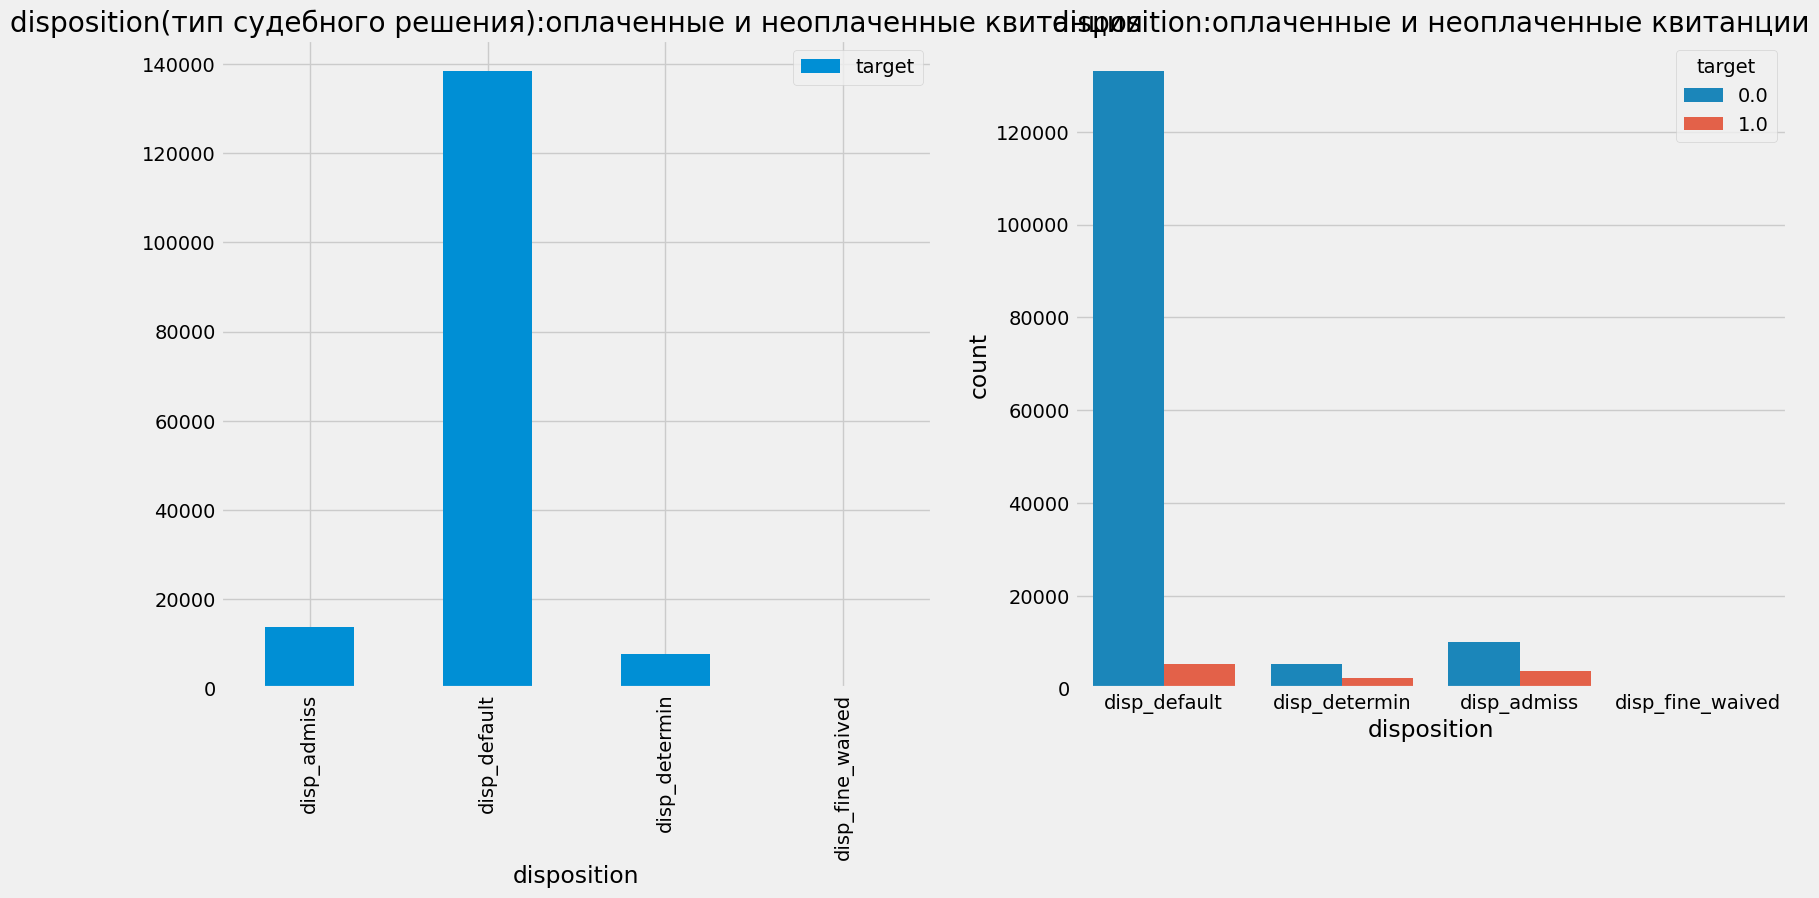

In [65]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df[['disposition','target']].groupby(['disposition']).count().plot.bar(ax=ax[0])
ax[0].set_title('disposition(тип судебного решения):оплаченные и неоплаченные квитанции')
sns.countplot(hue=df['target'], x=df['disposition'],ax=ax[1])
ax[1].set_title('disposition:оплаченные и неоплаченные квитанции')
plt.show()

In [33]:
df[df['disposition'] == 'disp_fine_waived'].groupby(['agency_name','target'])['target'].count()


agency_name    target
dep_buildings  1.0         7
dep_police     1.0        21
dep_pub_works  1.0       167
Name: target, dtype: int64

In [34]:
disposition_order = {'disp_default': 0,
                                'disp_determin': 1,
                                'disp_admiss': 2, 
                                'disp_fine_waived': 3}
df['disp_ordered'] = 0
df['disp_ordered'] = df['disposition'].apply(lambda x: disposition_order.get(x))
df['disp_ordered'].unique()

array([0, 1, 2, 3], dtype=int64)

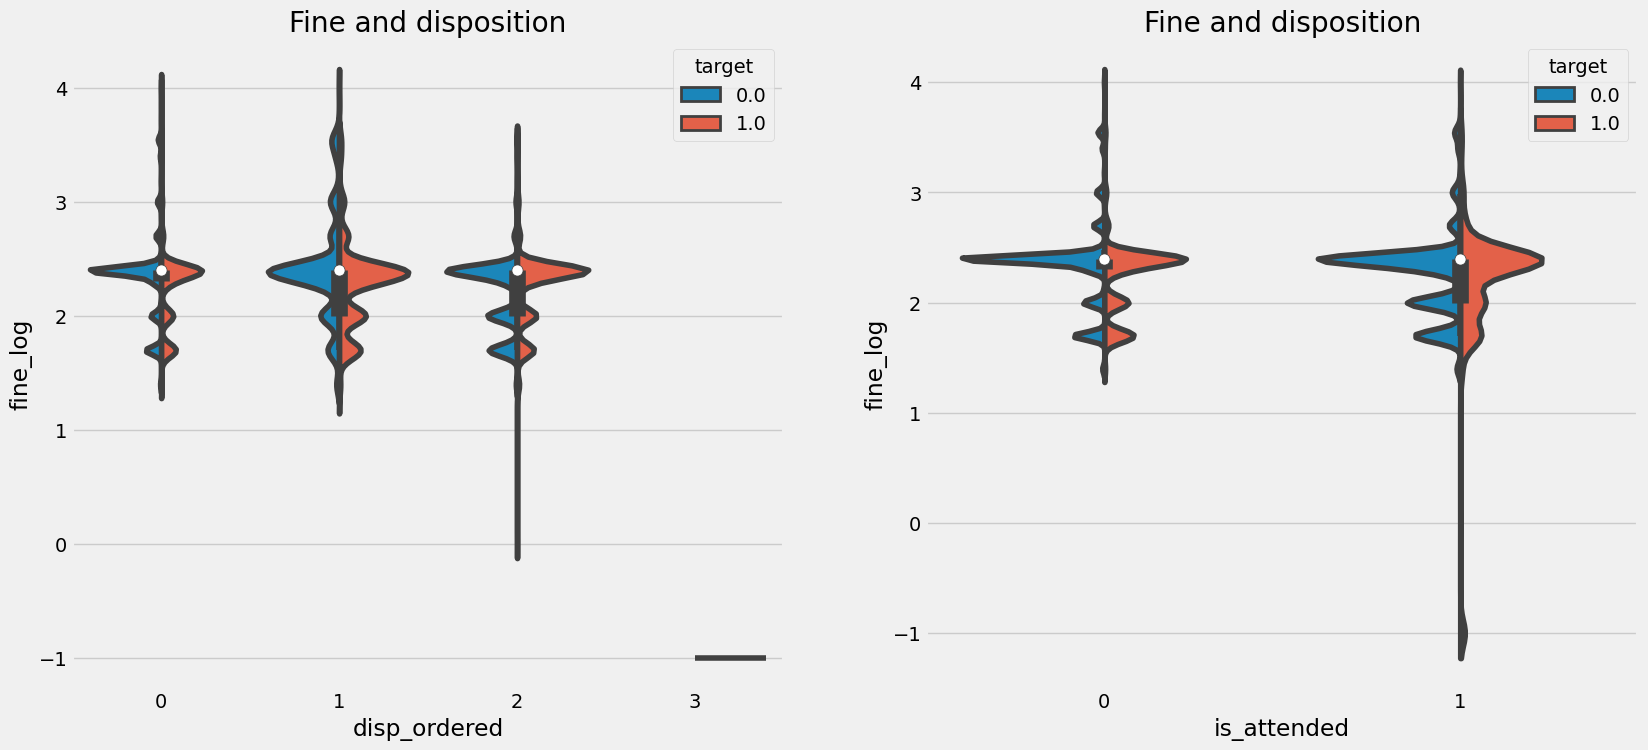

In [64]:
df['fine_log'] = 0.
df['fine_log'] = df['fine_amount'].apply(lambda x: np.log10(x) if x!=0 else -1)
df['is_attended'] = 0
df['is_attended'] = df['disp_ordered'].apply(lambda x: 1 if x in [1, 2, 3] else 0)
df['fine_log'].unique()
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot(y="fine_log",x="disp_ordered", hue="target", data=df,split=True,ax=ax[0])
ax[0].set_title('Fine and disposition')
ax[0].set_yticks(range(-1,5,1))
sns.violinplot(y="fine_log",x="is_attended", hue="target", data=df,split=True,ax=ax[1])
ax[1].set_title('Fine and disposition')
ax[1].set_yticks(range(-1,5,1))
plt.show()

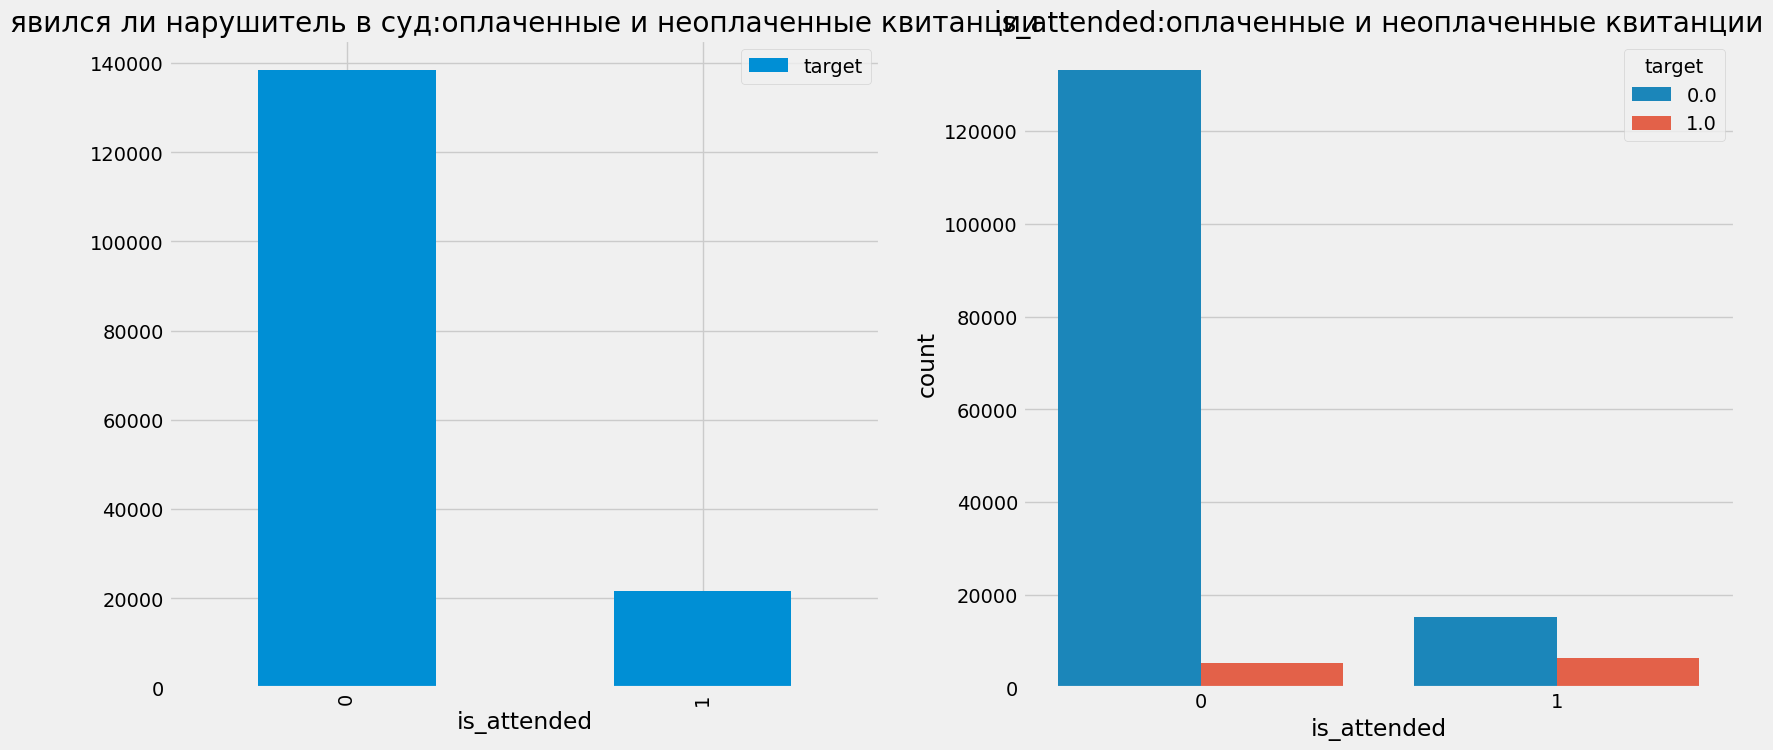

In [66]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df[['is_attended','target']].groupby(['is_attended']).count().plot.bar(ax=ax[0])
ax[0].set_title('явился ли нарушитель в суд:оплаченные и неоплаченные квитанции')
sns.countplot(hue=df['target'], x=df['is_attended'],ax=ax[1])
ax[1].set_title('is_attended:оплаченные и неоплаченные квитанции')
plt.show()

Если нарушитель пришел в суд это повышает вероятность оплаты штрафа

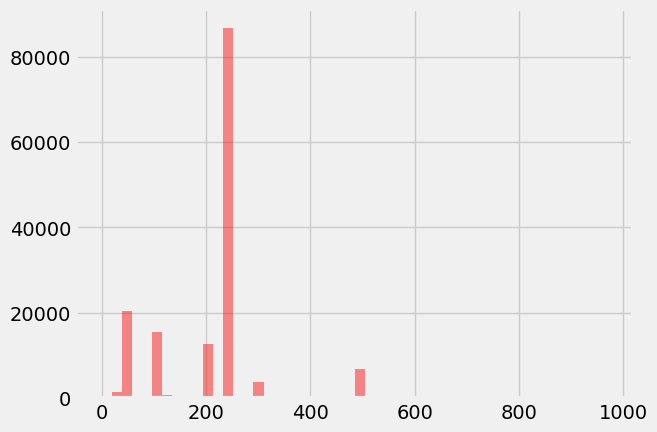

In [79]:
x = df[df['fine_amount']<1000]['fine_amount']

# the histogram of the data
plt.hist(x,bins = 50,
         alpha = 0.45, color = 'red')
plt.show()

In [137]:
# частота выписывания сумм штрафа и оплата
df_fine = df.groupby(['fine_amount']).agg({'target': ['sum', 'count']}).reset_index()

df_fine['paid_percent'] = df_fine['target']['sum'] / df_fine['target']['count'] * 100
print(df_fine)

   fine_amount  target        paid_percent
                   sum  count             
0          0.0   195.0    195   100.000000
1          1.0     1.0      1   100.000000
2         20.0     1.0      1   100.000000
3         25.0   107.0   1378     7.764877
4         50.0  1850.0  20415     9.061964
5         95.0     0.0      2     0.000000
6        100.0  1814.0  15488    11.712293
7        125.0    40.0    793     5.044136
8        150.0     1.0      2    50.000000
9        160.0     0.0      2     0.000000
10       170.0     0.0      1     0.000000
11       200.0  1271.0  12710    10.000000
12       220.0     1.0      4    25.000000
13       250.0  5477.0  86798     6.310053
14       270.0     1.0      1   100.000000
15       300.0   107.0   3768     2.839703
16       350.0     6.0    128     4.687500
17       400.0     2.0     39     5.128205
18       450.0     0.0      1     0.000000
19       500.0   374.0   6918     5.406187
20       600.0     0.0     10     0.000000
21       65

In [139]:
df.isnull().sum() #проверка пустых значений в данных

ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     26
violation_street_number            0
violation_street_name              0
violation_zip_code            159880
mailing_address_str_number      2558
mailing_address_str_name           3
city                               0
state                             84
zip_code                           1
non_us_str_code               159877
country                            0
ticket_issued_date                 0
hearing_date                     227
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
compliance_detail                  0
target                             0
address                            0
lat                                2
l

In [167]:
print(len(df['city'].unique()))
df['city_lower'] = df['city'].apply(lambda x: x.lower())
df_det = df[df['city_lower'].str.contains(r'^det.*', regex=True) & ~df['city_lower'].str.contains('detour', regex=False)]
detroit  = df_det['city_lower'].unique()
detroit 

4093


array(['detroit', 'det', 'det.', 'detrit', 'detoit', 'detriut',
       'detroit`', 'detroitdetroit', 'detroiot', 'detrjoit', 'detrot',
       'detrpot', 'detriot', 'detroti', 'detroirt', 'deteroit', 'detroi',
       'detroiti', 'detroitf', 'detrooit', 'detroiit', 'detorit',
       'detrorit', 'detroit1', 'detroitq', 'detrroit', 'deteoit',
       'detroit,', 'detrtoit', 'detaroit', 'dettroit', 'detrois',
       'detro;it', 'detr4oit', 'det,', 'detrioit', 'detropit',
       'detroit, mi. 48206', 'detrouit', 'detroit, mi.', 'detroir',
       'dettroitm', 'det roit', 'det., mi.', 'det.,', 'detroit  4',
       'det ,', 'det. mi.', 'detroity', 'detoriit', 'detyroit',
       'detroitl'], dtype=object)

In [169]:
df['is_detroit'] = df['city_lower'].apply(lambda x: 1 if x in detroit else 0)
# в детройте ли почтовый адрес или нет - не влияет заметно на факт оплаты
df.groupby(['is_detroit']).agg({'target': ['sum', 'count']}).reset_index()

is_detroit  target       
                 sum  count
0          0  4568.0  61841
1          1  7029.0  98039

In [206]:
adr_cols = ['violation_street_number', 'violation_street_name',
            'mailing_address_str_number', 'mailing_address_str_name', 'city', 'is_detroit', 'target',
            'address']

df.loc[:, adr_cols].head(20)
# если почтовый адрес PO box то реже платят
df['mailing_address_str_name'] = df['mailing_address_str_name'].fillna('')
df['mail_street'] = df['mailing_address_str_name'].apply(lambda x: x.lower())
df['is_pobox'] = df['mail_street'].str.contains('box')

In [211]:
# sum - оплачено, count - всего выписано штрафов
df.groupby(['is_pobox']).agg({'target': ['sum', 'count']})

target        
              sum   count
is_pobox                 
False     10999.0  144687
True        598.0   15193